# Прогнозирование оттока клиентов

По историческим данным поведения клиентов и расторжении договоров спрогнозировать возможный уход клиента. Построить модель с предельно большим значением *F1*-меры (0.59 и выше). Дополнительно измерение *AUC-ROC* и сравнение с *F1*-мерой.

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from catboost import Pool
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample, class_weight

In [7]:
data = pd.read_csv('/datasets/Churn.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [9]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [10]:
def change_case(str): 
    """From camel case to snake case"""
      
    return ''.join(['_'+i.lower() if i.isupper() else i for i in str]).lstrip('_') 

data.columns = map(change_case, data.columns)

Столбцы приведены к нижнему регистру, для удобства и соответствия PEP8.

In [11]:
data = pd.get_dummies(data, columns=['geography'], dtype='int', prefix_sep='')
data = pd.get_dummies(data, columns=['gender'], dtype='int', drop_first=True, prefix_sep='')

data.columns = map(change_case, data.columns)
data.rename(columns={'gender_male': 'is_male'}, inplace=True)

data = data[['row_number', 
             'customer_id', 
             'surname', 
             'credit_score', 
             'geography_france', 
             'geography_germany', 
             'geography_spain',
             'is_male',
             'age', 
             'tenure', 
             'balance', 
             'num_of_products', 
             'has_cr_card', 
             'is_active_member', 
             'estimated_salary', 
             'exited']]

В данных есть не существенные в данном прогнозе столбцы. `row_number` дублирует индексный столбец. Столбец `surname` являются персональными данными, так же не существенный в прогнозе.

In [12]:
data['customer_id'].unique().shape

(10000,)

Так как поле `customer_id` уникально, значит данных 10_000 уникальных клиентов. Это поле не существенно для прогноза.

In [13]:
data.loc[data['tenure'].isna(), 'tenure'] = data.loc[data['tenure'].isna() == False, 'tenure'].median()

Признак количества недвижимости у клиента содержит пропуски, можно заменить их на значение медианы.

In [14]:
scaler_columns = data.drop(columns=['row_number', 
                                    'customer_id', 
                                    'surname', 
                                    'geography_france', 
                                    'geography_germany', 
                                    'geography_spain', 
                                    'is_male', 
                                    'has_cr_card', 
                                    'is_active_member', 
                                    'exited']).columns.to_list()

scaler = StandardScaler()
data.loc[:, scaler_columns] = pd.DataFrame(scaler.fit_transform(data.loc[:, scaler_columns]), index=data.index, columns=scaler_columns)

In [15]:
data.head()

,row_number,customer_id,surname,credit_score,geography_france,geography_germany,geography_spain,is_male,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,-0.326221,1,0,0,0,0.293517,-1.086246,-1.225848,-0.911583,1,1,0.021886,1
1,2,15647311,Hill,-0.440036,0,0,1,0,0.198164,-1.448581,0.117350,-0.911583,0,1,0.216534,0
2,3,15619304,Onio,-1.536794,1,0,0,0,0.293517,1.087768,1.333053,2.527057,1,0,0.240687,1
3,4,15701354,Boni,0.501521,1,0,0,0,0.007457,-1.448581,-1.225848,0.807737,0,0,-0.108918,0
4,5,15737888,Mitchell,2.063884,0,0,1,0,0.388871,-1.086246,0.785728,-0.911583,1,1,-0.365276,0


## 2. Исследование задачи

In [16]:
features = data.drop(columns=['customer_id', 'row_number', 'surname', 'exited'], axis=1)
target = data['exited']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=123456)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=123456)

### 2.1 Исследование баланса классов

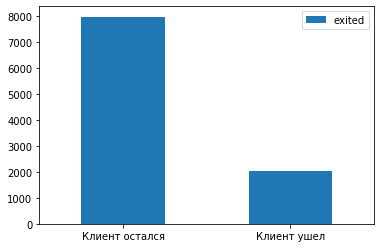

In [17]:
exited_counts = data['exited'].value_counts()
exited_counts.plot(kind='bar', legend=['факт ухода клиента'])

plt.xticks(ticks=exited_counts.index, labels=['Клиент остался', 'Клиент ушел'], rotation=0)
plt.show()

In [18]:
print(f'Соотношение оставшихся клиентов к ушедшим: {(exited_counts[1] / exited_counts[0]):0.2f}')

Соотношение оставшихся клиентов к ушедшим: 0.26


In [19]:
model_lr = LogisticRegression(random_state=123456, solver='lbfgs')
model_lr.fit(features_train, target_train)

predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid_lr)
f1_lr = f1_score(target_valid, predicted_valid_lr)

print(f'{type(model_lr).__name__}: F1-score = {f1_lr:0.2f}, AUC-ROC = {roc_auc_lr:0.2f}')

print(confusion_matrix(target_valid, predicted_valid_lr))

LogisticRegression: F1-score = 0.26, AUC-ROC = 0.77
[[1522   57]
 [ 348   73]]


In [20]:
model_dt = DecisionTreeClassifier(random_state=123456)
model_dt.fit(features_train, target_train)

predicted_valid_dt = model_dt.predict(features_valid)

probabilities_valid_dt = model_dt.predict_proba(features_valid)
probabilities_one_valid_dt = probabilities_valid_dt[:, 1]

roc_auc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)
f1_dt = f1_score(target_valid, predicted_valid_dt)

print(f'{type(model_dt).__name__}: F1-score = {f1_dt:0.2f}, AUC-ROC = {roc_auc_dt:0.2f}')

print(confusion_matrix(target_valid, predicted_valid_dt))

DecisionTreeClassifier: F1-score = 0.46, AUC-ROC = 0.65
[[1367  212]
 [ 234  187]]


In [21]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=123456)
model_rf.fit(features_train, target_train)

predicted_valid_rf = model_rf.predict(features_valid)

probabilities_valid_rf = model_rf.predict_proba(features_valid)
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]

roc_auc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
f1_rf = f1_score(target_valid, predicted_valid_rf)

print(f'{type(model_rf).__name__}: F1-score = {f1_rf:0.2f}, AUC-ROC = {roc_auc_rf:0.2f}')

print(confusion_matrix(target_valid, predicted_valid_rf))

RandomForestClassifier: F1-score = 0.55, AUC-ROC = 0.85
[[1528   51]
 [ 244  177]]


In [ ]:
train_pool = Pool(features_train, target_train)
valid_pool = Pool(features_valid, target_valid)

cat_model = CatBoostClassifier(iterations=1000, eval_metric='F1', random_state=123456)
cat_model.fit(train_pool, eval_set=valid_pool, verbose=100)

predicted_valid_cat = cat_model.predict(features_valid)

probabilities_valid_cat = cat_model.predict_proba(features_valid)
probabilities_one_valid_cat = probabilities_valid_cat[:, 1]

roc_auc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)

print()
print(f'{type(cat_model).__name__}: AUC-ROC = {roc_auc_cat:0.2f}')

Обучив несколько моделей определил что требуемого значения F1-меры не получить без учета дисбаланса классов. 

Сравнение F1-меры и AUC-ROC показывает, что величина AUC-ROC не подходит для измерения качества моделей на разбалансированных данных. Вероятная причина: ложноположительный показатель для сильно несбалансированных наборов данных снижается из-за большого количества истинно ложных результатов.

## 3. Борьба с дисбалансом

### 3.1 Увеличение выборки

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    sample = len(features_ones) * repeat
    
    features_ones = resample(features_ones, replace=True, n_samples=sample, random_state=123456)
    target_ones = resample(target_ones, replace=True, n_samples=sample, random_state=123456)
    
    features_upsampled = pd.concat([features_zeros, features_ones])
    target_upsampled = pd.concat([target_zeros, target_ones])

    return features_upsampled, target_upsampled

In [23]:
print(target_train[target_train == 0].shape)
print(target_train[target_train == 1].shape)

(4786,)
(1214,)


In [24]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(len(features_upsampled[target_upsampled == 0]))
print(len(features_upsampled[target_upsampled == 1]))

4786
4856


In [25]:
model_lr = LogisticRegression(random_state=123456, solver='lbfgs')
model_lr.fit(features_upsampled, target_upsampled)

predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid_lr)
f1_lr = f1_score(target_valid, predicted_valid_lr)

print(f'{type(model_lr).__name__}: F1-score = {f1_lr:0.2f}, AUC-ROC = {roc_auc_lr:0.2f}')

LogisticRegression: F1-score = 0.51, AUC-ROC = 0.77


In [26]:
model_dt = DecisionTreeClassifier(random_state=123456)
model_dt.fit(features_upsampled, target_upsampled)

predicted_valid_dt = model_dt.predict(features_valid)

probabilities_valid_dt = model_dt.predict_proba(features_valid)
probabilities_one_valid_dt = probabilities_valid_dt[:, 1]

roc_auc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)
f1_dt = f1_score(target_valid, predicted_valid_dt)

print(f'{type(model_dt).__name__}: F1-score = {f1_dt:0.2f}, AUC-ROC = {roc_auc_dt:0.2f}')

DecisionTreeClassifier: F1-score = 0.48, AUC-ROC = 0.67


In [27]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=123456)
model_rf.fit(features_upsampled, target_upsampled)

predicted_valid_rf = model_rf.predict(features_valid)

probabilities_valid_rf = model_rf.predict_proba(features_valid)
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]

roc_auc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
f1_rf = f1_score(target_valid, predicted_valid_rf)

print(f'{type(model_rf).__name__}: F1-score = {f1_rf:0.2f}, AUC-ROC = {roc_auc_rf:0.2f}')

RandomForestClassifier: F1-score = 0.58, AUC-ROC = 0.85


In [28]:
train_pool = Pool(features_upsampled, target_upsampled)
valid_pool = Pool(features_valid, target_valid)

cat_model = CatBoostClassifier(iterations=1000, eval_metric='F1', random_state=123456)
cat_model.fit(train_pool, eval_set=valid_pool, verbose=100)

predicted_valid_cat = cat_model.predict(features_valid)

probabilities_valid_cat = cat_model.predict_proba(features_valid)
probabilities_one_valid_cat = probabilities_valid_cat[:, 1]

roc_auc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)

print()
print(f'{type(cat_model).__name__}: AUC-ROC = {roc_auc_cat:0.2f}')

Learning rate set to 0.098989
0:	learn: 0.7542869	test: 0.5722488	best: 0.5722488 (0)	total: 55.6ms	remaining: 55.5s
100:	learn: 0.8614333	test: 0.6287487	best: 0.6337449 (88)	total: 3.02s	remaining: 26.9s
200:	learn: 0.9163014	test: 0.6148867	best: 0.6337449 (88)	total: 5.81s	remaining: 23.1s
300:	learn: 0.9448128	test: 0.6056497	best: 0.6337449 (88)	total: 8.82s	remaining: 20.5s
400:	learn: 0.9608745	test: 0.6116838	best: 0.6337449 (88)	total: 11.7s	remaining: 17.4s
500:	learn: 0.9744585	test: 0.6133960	best: 0.6337449 (88)	total: 14.6s	remaining: 14.5s
600:	learn: 0.9827145	test: 0.6002401	best: 0.6337449 (88)	total: 17.6s	remaining: 11.7s
700:	learn: 0.9886119	test: 0.5968331	best: 0.6337449 (88)	total: 20.7s	remaining: 8.81s
800:	learn: 0.9916778	test: 0.5938650	best: 0.6337449 (88)	total: 23.6s	remaining: 5.86s
900:	learn: 0.9948613	test: 0.5853051	best: 0.6337449 (88)	total: 26.5s	remaining: 2.92s
999:	learn: 0.9971193	test: 0.5860349	best: 0.6337449 (88)	total: 29.5s	remaining:

### 3.2 Уменьшение выборки

In [29]:
def downsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    sample = int(len(features_zeros) * repeat)
    
    features_zeros = resample(features_zeros, replace=True, n_samples=sample, random_state=123456)
    target_zeros = resample(target_zeros, replace=True, n_samples=sample, random_state=123456)
    
    features_downsampled = pd.concat([features_zeros, features_ones])
    target_downsampled = pd.concat([target_zeros, target_ones])

    return features_downsampled, target_downsampled

In [30]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

print(features_downsampled[target_downsampled == 0].shape)
print(features_downsampled[target_downsampled == 1].shape)

(1914, 12)
(1214, 12)


In [31]:
model_lr = LogisticRegression(random_state=123456, solver='lbfgs')
model_lr.fit(features_downsampled, target_downsampled)

predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid_lr)
f1_lr = f1_score(target_valid, predicted_valid_lr)

print(f'{type(model_lr).__name__}: F1-score = {f1_lr:0.2f}, AUC-ROC = {roc_auc_lr:0.2f}')

LogisticRegression: F1-score = 0.49, AUC-ROC = 0.77


In [32]:
model_dt = DecisionTreeClassifier(random_state=123456)
model_dt.fit(features_downsampled, target_downsampled)

predicted_valid_dt = model_dt.predict(features_valid)

probabilities_valid_dt = model_dt.predict_proba(features_valid)
probabilities_one_valid_dt = probabilities_valid_dt[:, 1]

roc_auc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)
f1_dt = f1_score(target_valid, predicted_valid_dt)

print(f'{type(model_dt).__name__}: F1-score = {f1_dt:0.2f}, AUC-ROC = {roc_auc_dt:0.2f}')

DecisionTreeClassifier: F1-score = 0.52, AUC-ROC = 0.71


In [33]:
model_rf = RandomForestClassifier(random_state=123456, n_estimators=100)
model_rf.fit(features_downsampled, target_downsampled)

predicted_valid_rf = model_rf.predict(features_valid)

probabilities_valid_rf = model_rf.predict_proba(features_valid)
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]

roc_auc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
f1_rf = f1_score(target_valid, predicted_valid_rf)

print(f'{type(model_rf).__name__}: F1 score = {f1_rf:0.2f}, AUC-ROC = {roc_auc_rf:0.2f}')

RandomForestClassifier: F1 score = 0.62, AUC-ROC = 0.85


In [34]:
train_pool = Pool(features_downsampled, target_downsampled)
valid_pool = Pool(features_valid, target_valid)

cat_model = CatBoostClassifier(iterations=1000, eval_metric='F1', random_state=123456)
cat_model.fit(train_pool, eval_set=valid_pool, verbose=100)

predicted_valid_cat = cat_model.predict(features_valid)

probabilities_valid_cat = cat_model.predict_proba(features_valid)
probabilities_one_valid_cat = probabilities_valid_cat[:, 1]

roc_auc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)

print()
print(f'{type(cat_model).__name__} AUC-ROC = {roc_auc_cat:0.2f}')

Learning rate set to 0.087954
0:	learn: 0.7003793	test: 0.5672576	best: 0.5672576 (0)	total: 3.79ms	remaining: 3.79s
100:	learn: 0.8080986	test: 0.6257110	best: 0.6337543 (88)	total: 2.36s	remaining: 21s
200:	learn: 0.8845486	test: 0.6090713	best: 0.6337543 (88)	total: 4.6s	remaining: 18.3s
300:	learn: 0.9204594	test: 0.6016771	best: 0.6337543 (88)	total: 6.94s	remaining: 16.1s
400:	learn: 0.9503367	test: 0.5939772	best: 0.6337543 (88)	total: 9.27s	remaining: 13.8s
500:	learn: 0.9664992	test: 0.5934292	best: 0.6337543 (88)	total: 11.5s	remaining: 11.5s
600:	learn: 0.9850374	test: 0.5839268	best: 0.6337543 (88)	total: 13.8s	remaining: 9.18s
700:	learn: 0.9913115	test: 0.5836735	best: 0.6337543 (88)	total: 16.2s	remaining: 6.89s
800:	learn: 0.9975227	test: 0.5833333	best: 0.6337543 (88)	total: 18.4s	remaining: 4.57s
900:	learn: 0.9975227	test: 0.5780933	best: 0.6337543 (88)	total: 20.8s	remaining: 2.29s
999:	learn: 0.9991756	test: 0.5763747	best: 0.6337543 (88)	total: 23.2s	remaining: 0u

### 3.3 Изменение порога

In [35]:
def calc_threshold(probabilities):
    result = []
    
    for threshold in np.arange(0, 0.3, 0.01):
        predicted_valid = probabilities > threshold
        
        _f1_score = f1_score(target_valid, predicted_valid)
        _roc_auc = roc_auc_score(target_valid, predicted_valid)
        
        scores_dict = {'threshold': threshold, 'f1_score': _f1_score, 'AUC-ROC': _roc_auc}
        result.append(scores_dict)
    
    result.sort(key=lambda item: item['f1_score'], reverse=True)
    return result[0]

In [36]:
model = LogisticRegression(random_state=123456, solver='lbfgs')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

_threshold_score, _f1_score, _roc_auc = calc_threshold(probabilities_one_valid).values()
print(f'{type(model).__name__}: Порог = {_threshold_score:.2f} F1-мера = {_f1_score:.3f}, AUC-ROC = {_roc_auc:.3f}')

LogisticRegression: Порог = 0.22 F1-мера = 0.513, AUC-ROC = 0.708


In [37]:
model = DecisionTreeClassifier(random_state=123456)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

_threshold_score, _f1_score, _roc_auc = calc_threshold(probabilities_one_valid).values()
print(f'{type(model).__name__}: Порог = {_threshold_score:.2f} F1-мера = {_f1_score:.3f}, AUC-ROC = {_roc_auc:.3f}')

DecisionTreeClassifier: Порог = 0.00 F1-мера = 0.456, AUC-ROC = 0.655


In [38]:
model = RandomForestClassifier(random_state=123456, n_estimators=100)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

_threshold_score, _f1_score, _roc_auc = calc_threshold(probabilities_one_valid).values()
print(f'{type(model).__name__}: Порог = {_threshold_score:.2f} F1-мера = {_f1_score:.3f}, AUC-ROC = {_roc_auc:.3f}')

RandomForestClassifier: Порог = 0.23 F1-мера = 0.603, AUC-ROC = 0.771


### 3.4 Другие способы борьбы с дисбалансом

In [39]:
model = LogisticRegression(random_state=123456, solver='lbfgs', class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
roc_auc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)

print(f'{type(model).__name__}: F1-мера = {f1:.3f}, AUC-ROC = {roc_auc_cat:0.2f}')

LogisticRegression: F1-мера = 0.514, AUC-ROC = 0.87


In [40]:
model = LogisticRegression(random_state=123456, solver='lbfgs', class_weight={0: 0.26, 1: 1})
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
roc_auc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)

print(f'{type(model).__name__}: F1-мера = {f1:.3f}, AUC-ROC = {roc_auc_cat:0.2f}')

LogisticRegression: F1-мера = 0.516, AUC-ROC = 0.87


In [41]:
model_dt = DecisionTreeClassifier(random_state=123456, class_weight='balanced')
model_dt.fit(features_train, target_train)

predicted_valid_dt = model_dt.predict(features_valid)
probabilities_valid_dt = model_dt.predict_proba(features_valid)
probabilities_one_valid_dt = probabilities_valid_dt[:, 1]

roc_auc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)
f1_dt = f1_score(target_valid, predicted_valid_dt)

print(f'{type(model_dt).__name__}: F1-score = {f1_dt:0.2f}, AUC-ROC = {roc_auc_dt:0.2f}')

DecisionTreeClassifier: F1-score = 0.49, AUC-ROC = 0.67


In [42]:
model_dt = DecisionTreeClassifier(random_state=123456, class_weight={0: 0.26, 1: 1})
model_dt.fit(features_train, target_train)

predicted_valid_dt = model_dt.predict(features_valid)
probabilities_valid_dt = model_dt.predict_proba(features_valid)
probabilities_one_valid_dt = probabilities_valid_dt[:, 1]

roc_auc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)
f1_dt = f1_score(target_valid, predicted_valid_dt)

print(f'{type(model_dt).__name__}: F1-score = {f1_dt:0.2f}, AUC-ROC = {roc_auc_dt:0.2f}')

DecisionTreeClassifier: F1-score = 0.50, AUC-ROC = 0.68


In [43]:
model_rf = RandomForestClassifier(random_state=123456, n_estimators=100, class_weight='balanced')
model_rf.fit(features_train, target_train)

predicted_valid_rf = model_rf.predict(features_valid)

probabilities_valid_rf = model_rf.predict_proba(features_valid)
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]

roc_auc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
f1_rf = f1_score(target_valid, predicted_valid_rf)

print(f'{type(model_rf).__name__}: F1 score = {f1_rf:0.2f}, AUC-ROC = {roc_auc_rf:0.2f}')

RandomForestClassifier: F1 score = 0.53, AUC-ROC = 0.85


In [44]:
model_rf = RandomForestClassifier(random_state=123456, n_estimators=100, class_weight={0: 0.26, 1: 1})
model_rf.fit(features_train, target_train)

predicted_valid_rf = model_rf.predict(features_valid)

probabilities_valid_rf = model_rf.predict_proba(features_valid)
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]

roc_auc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
f1_rf = f1_score(target_valid, predicted_valid_rf)

print(f'{type(model_rf).__name__}: F1 score = {f1_rf:0.2f}, AUC-ROC = {roc_auc_rf:0.2f}')

RandomForestClassifier: F1 score = 0.52, AUC-ROC = 0.85


In [45]:
train_pool = Pool(features_train, target_train)
valid_pool = Pool(features_valid, target_valid)

cat_model = CatBoostClassifier(iterations=1000, eval_metric='F1', random_state=123456, auto_class_weights='Balanced')
cat_model.fit(train_pool, eval_set=valid_pool, verbose=100)

predicted_valid_cat = cat_model.predict(features_valid)

probabilities_valid_cat = cat_model.predict_proba(features_valid)
probabilities_one_valid_cat = probabilities_valid_cat[:, 1]

roc_auc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)

print()
print(f'{type(cat_model).__name__} AUC-ROC = {roc_auc_cat:0.2f}')

TypeError: __init__() got an unexpected keyword argument 'auto_class_weights'

Наибольший результат получен с помощью классификатора `Catboost` с параметром автоматического вычисления весов для классов. 

Второй по результату классификатор `RandomForestClassifier` с уменьшением в выборки доли отрицательных результатов, можно попробовать улучшить результат модели подбором параметров модели.

In [46]:
def train_random_forest_classifier(features, target, n_estimators, random_state, **kwargs):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=123456, **kwargs)
    model.fit(features, target)
    
    return model 


def get_score_random_forest_classifier(features_train, 
                                       target_train, 
                                       features_valid, 
                                       target_valid, 
                                       start_estimators, max_estimators, step_estimators, 
                                       start_depth, max_depth, step_depth,
                                       random_state, **kwargs):
    result = []
    
    for estimator in range(start_estimators, max_estimators, step_estimators):
        for depth in range(start_depth, max_depth, step_depth):
            model = train_random_forest_classifier(features=features_train, target=target_train, 
                                                   n_estimators=estimator, max_depth=depth, 
                                                   random_state=random_state, **kwargs)
            
            predicted_valid = model.predict(features_valid)

            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            _f1_score = f1_score(target_valid, predicted_valid)
            _roc_auc = roc_auc_score(target_valid, predicted_valid)

            scores_dict = {'model_name': type(model).__name__, 'n_estimators': estimator, 'max_depth': depth, 'f1_score': _f1_score, 'AUC-ROC': _roc_auc}
            result.append(scores_dict)

    result.sort(key=lambda item: item['f1_score'], reverse=True)
    return result[0]

In [ ]:
random_forest_score = get_score_random_forest_classifier(features_train, target_train, 
                                                         features_valid, target_valid, 
                                                         start_estimators=100, max_estimators=301, step_estimators=10,
                                                         start_depth=1, max_depth=21, step_depth=1,
                                                         random_state=123456, class_weight='balanced') 

print(f'Лучший результат модели {random_forest_score["model_name"]}: '
      f'n_estimators = {random_forest_score["n_estimators"]}, max_depth: {random_forest_score["max_depth"]}, '
      f'f1_score = {random_forest_score["f1_score"]}, AUC-ROC: {random_forest_score["AUC-ROC"]}')

In [ ]:
random_forest_score = get_score_random_forest_classifier(features_upsampled, target_upsampled, 
                                                         features_valid, target_valid, 
                                                         start_estimators=100, max_estimators=301, step_estimators=10,
                                                         start_depth=1, max_depth=21, step_depth=1,
                                                         random_state=123456) 

print(f'Лучший результат модели {random_forest_score["model_name"]}: '
      f'n_estimators = {random_forest_score["n_estimators"]}, max_depth: {random_forest_score["max_depth"]}, '
      f'f1_score = {random_forest_score["f1_score"]}, AUC-ROC: {random_forest_score["AUC-ROC"]}')

In [ ]:
random_forest_score = get_score_random_forest_classifier(features_downsampled, target_downsampled, 
                                                         features_valid, target_valid, 
                                                         start_estimators=100, max_estimators=301, step_estimators=10,
                                                         start_depth=1, max_depth=21, step_depth=1,
                                                         random_state=123456) 

print(f'Лучший результат модели {random_forest_score["model_name"]}: '
      f'n_estimators = {random_forest_score["n_estimators"]}, max_depth: {random_forest_score["max_depth"]}, '
      f'f1_score = {random_forest_score["f1_score"]}, AUC-ROC: {random_forest_score["AUC-ROC"]}')

Существенного улучшения модели `F1-мера = 0.62, AUC-ROC = 0.85` подбором параметров не произошло. Площадь `ROC-кривой` снизилась, значит снизилась доля истинно положительных прогнозов. Так же подбор параметров привел к увеличению размера и времени расчета модели.

## 4. Тестирование модели

In [ ]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=123456)
dummy_clf.fit(features_train, target_train)

dummy_predicted_valid = dummy_clf.predict(features_valid)
dummy_probabilities_valid = dummy_clf.predict_proba(features_valid)
dummy_probabilities_one_valid = dummy_probabilities_valid[:, 1]

dummy_f1_score = f1_score(target_valid, dummy_predicted_valid)
dummy_roc_auc = roc_auc_score(target_valid, dummy_probabilities_one_valid)

print(f'Результат случайной модели на тестовой выборке: F1-мера = {dummy_f1_score:0.3f}, AUC-ROC = {dummy_roc_auc:.3f}')

Результат случайной модели на тестовой выборке показывает **F1-меру** меньшую чем случайный лес `RandomForestClassifier` и CatBoost `CatBoostClassifier. Площадь ROC-кривой так же характерна для случайной модели. 

По результатам тестированиям модели можно выделить две с наибольшими результатами. Это случайны лес `RandomForestClassifier`с уменьшением в выборке доли отрицательных результатов и CatBoost `CatBoostClassifier`. Обе модели модели показали значение F1-меры выше требуемого значения.